Dataset - https://www.kaggle.com/c/dogs-vs-cats/data \
The training data contains 25,000 images of cats and dogs. Our goal is to train a model to correctly classify an image as a cat or a dog. We'll be using transfer learning from base models in keras to fine tune it for our specific task. \
Multiple model - hyperparamter combinations were tried. Broadly, transfer learning was applied on base models of Xception and InceptionResNetV2. The code with best results only is shown.

In [1]:
import pandas as pd
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Input, metrics, losses
import warnings
warnings.filterwarnings('ignore')
LOCAL_PATH = '../data'
KAGGLE_PATH = '/kaggle'
PATH = KAGGLE_PATH
cwd = os.getcwd()

In [2]:
base_dir = os.path.join(PATH, "input/dogs-vs-cats-redux-kernels-edition")
train_dir = os.path.join(base_dir, "train.zip")
test_dir = os.path.join(base_dir, "test.zip")

with zipfile.ZipFile(train_dir,"r") as z:
    z.extractall()

with zipfile.ZipFile(test_dir,"r") as z:
    z.extractall()

Training data is put under train/cat and train/dog with respect to their labels. Test data is put under test/test_files to make it compatible with flow_from_directory.

In [3]:
def make_dir(dir):
    for d in dir:
        new_path = cwd+'/train/'+d
        os.makedirs(new_path,exist_ok=True)
    print('make_dir complete')
        
def move_files():
    n_train_cats = 0
    n_train_dogs = 0
    train_path = cwd+'/train/'
    test_path = cwd+'/test/'
    
    pic_paths = os.listdir(train_path)
    for i in tqdm(pic_paths):
        if 'jpg' in i:
            if 'dog' in i:
                os.rename(train_path+i,train_path+'dog/'+i )
                n_train_dogs+=1
            elif 'cat' in i:
                os.rename(train_path+i,train_path+'cat/'+i )
                n_train_cats+=1
                
    pic_paths = os.listdir(test_path)
    os.makedirs(test_path+'test_files',exist_ok=True)
    for i in tqdm(pic_paths):
        if 'jpg' in i:
            os.rename(test_path+i, test_path+'test_files/'+i)
    return n_train_cats, n_train_dogs

In [4]:
make_dir(['cat', 'dog'])

make_dir complete


In [5]:
n_train_cats, n_train_dogs = move_files()
# mv  ./dog.* ./dog

100%|██████████| 12500/12500 [00:00<00:00, 52583.18it/s]


In [6]:
n_train_cats, n_train_dogs

(12500, 12500)

Multiple combinations of data augmentation were tried along with different input image shapes and varying batch sizes.

In [7]:
train_path = cwd+'/train/'
test_path = cwd+'/test/'
size = (300, 300)

train_data_gen = ImageDataGenerator(
#     rotation_range=20,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    validation_split=0.2)

val_data_gen = ImageDataGenerator(
    validation_split=0.2)

train_data = train_data_gen.flow_from_directory(
        train_path,
        target_size=size,
        batch_size=32,
        seed=29,
        subset='training',
        class_mode='binary'
)

val_data = val_data_gen.flow_from_directory(
        train_path,
        target_size=size,
        batch_size=32,
        seed=29,
        class_mode='binary',
        subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
train_data.class_indices

{'cat': 0, 'dog': 1}

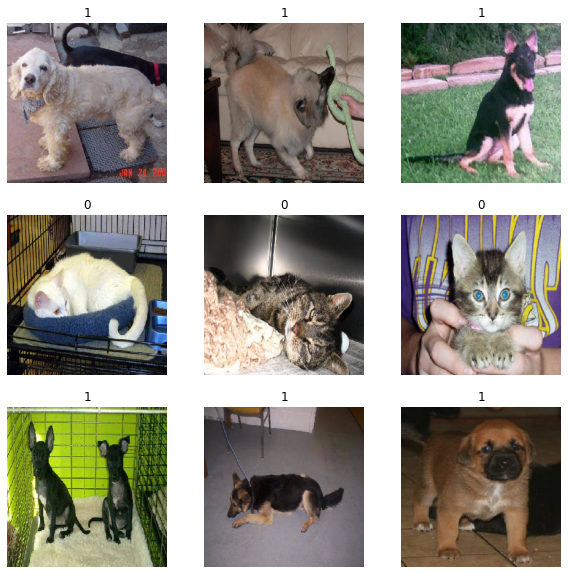

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
        image = train_data[1][0][i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((image/255))
        plt.title(int(train_data[1][1][i]))
        plt.axis("off")

In [10]:
base_model = keras.applications.Xception(
    include_top=False,
    input_shape=(300, 300, 3),
    weights="imagenet"
)
# base_model = keras.applications.InceptionResNetV2(
#     include_top=False,
#     input_shape=(300, 300, 3),
#     weights="imagenet"
# )

2022-04-05 14:20:59.588604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 14:20:59.737157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 14:20:59.738010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 14:20:59.740571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 1s 0us/step


In [11]:
# for layer in base_model.layers[:-5]:
#     layer.trainable = False
# base_model.summary()
base_model.trainable = False

In [12]:
inputs = Input(shape=(300, 300, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# outputs = Dense(2,activation='softmax')(x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_____________________________________________

In [13]:
# model_checkpoint_callback  = ModelCheckpoint(filepath = '../working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only = True, mode = 'min')
model_checkpoint_callback  = ModelCheckpoint(filepath = '../working/best_model.hdf5', save_best_only = True, mode = 'min')
model_stopping_callback  = EarlyStopping(patience=10,mode='min',restore_best_weights=True)
callbacks = [model_stopping_callback, model_checkpoint_callback]

Different combinations of momentum and learning rates were tried.

In [14]:
sgd_optimizer = tf.keras.optimizers.SGD(momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd_optimizer,loss=losses.BinaryCrossentropy(),metrics=[metrics.BinaryAccuracy()])

In [15]:
history = model.fit(train_data,epochs=20,
                    validation_data=val_data,
                    callbacks=callbacks)

2022-04-05 14:21:06.989981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-04-05 14:21:10.237889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 152s 230ms/step - loss: 0.0502 - binary_accuracy: 0.9877 - val_loss: 0.0254 - val_binary_accuracy: 0.9934
Epoch 2/20
625/625 [==============================] - 143s 229ms/step - loss: 0.0234 - binary_accuracy: 0.9934 - val_loss: 0.0228 - val_binary_accuracy: 0.9930
Epoch 3/20
625/625 [==============================] - 143s 229ms/step - loss: 0.0200 - binary_accuracy: 0.9941 - val_loss: 0.0210 - val_binary_accuracy: 0.9936
Epoch 4/20
625/625 [==============================] - 144s 229ms/step - loss: 0.0183 - binary_accuracy: 0.9945 - val_loss: 0.0216 - val_binary_accuracy: 0.9936
Epoch 5/20
625/625 [==============================] - 145s 232ms/step - loss: 0.0176 - binary_accuracy: 0.9949 - val_loss: 0.0202 - val_binary_accuracy: 0.9940
Epoch 6/20
625/625 [==============================] - 145s 232ms/step - loss: 0.0166 - binary_accuracy: 0.9947 - val_loss: 0.0204 - val_binary_accuracy: 0.9938
Epoch 7/20
625/625 [==============================]

In [16]:
# model_dir = os.path.join(PATH, "input/best-model/weights.12-0.03.hdf5")
# best_model = load_model('./weights.12-0.02.hdf5')

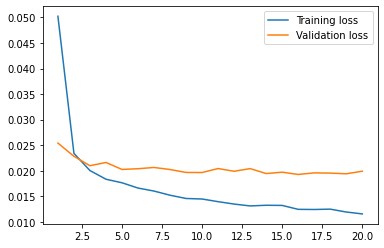

In [17]:
epochs = list(range(1,len(history.history['loss'])+1))
plt.plot(epochs, history.history['loss'], epochs, history.history['val_loss'])
plt.legend(('Training loss','Validation loss'))
plt.show()

In [18]:
best_model = load_model('./best_model.hdf5')
best_model.trainable = True
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
____________________________________________

In [19]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum = 0.9, nesterov = True)
best_model.compile(optimizer=sgd_optimizer,loss=losses.BinaryCrossentropy(),metrics=[metrics.BinaryAccuracy()])

In [20]:
history = best_model.fit(train_data,epochs=20,
                    validation_data=val_data,
                    callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 512s 812ms/step - loss: 0.0119 - binary_accuracy: 0.9963 - val_loss: 0.0194 - val_binary_accuracy: 0.9938
Epoch 2/20
625/625 [==============================] - 495s 792ms/step - loss: 0.0113 - binary_accuracy: 0.9966 - val_loss: 0.0194 - val_binary_accuracy: 0.9938
Epoch 3/20
625/625 [==============================] - 495s 792ms/step - loss: 0.0111 - binary_accuracy: 0.9969 - val_loss: 0.0193 - val_binary_accuracy: 0.9938
Epoch 4/20
625/625 [==============================] - 495s 793ms/step - loss: 0.0111 - binary_accuracy: 0.9964 - val_loss: 0.0192 - val_binary_accuracy: 0.9938
Epoch 5/20
625/625 [==============================] - 496s 793ms/step - loss: 0.0106 - binary_accuracy: 0.9970 - val_loss: 0.0192 - val_binary_accuracy: 0.9940
Epoch 6/20
625/625 [==============================] - 496s 793ms/step - loss: 0.0102 - binary_accuracy: 0.9968 - val_loss: 0.0191 - val_binary_accuracy: 0.9940
Epoch 7/20
625/625 [====================

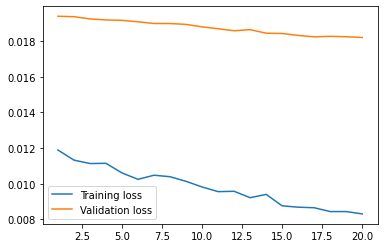

In [21]:
epochs = list(range(1,len(history.history['loss'])+1))
plt.plot(epochs, history.history['loss'], epochs, history.history['val_loss'])
plt.legend(('Training loss','Validation loss'))
plt.show()

In [22]:
test_data_gen = ImageDataGenerator()

test_data = val_data_gen.flow_from_directory(
        test_path,
        target_size=size,
        shuffle=False,
        class_mode=None)

Found 12500 images belonging to 1 classes.


In [23]:
best_model = load_model('./best_model.hdf5')
# y_pred = tf.nn.sigmoid(best_model.predict(test_data)).numpy().flatten()
y_pred = best_model.predict(test_data).flatten()

In [24]:
# submission = pd.DataFrame({'id':pd.Series(test_data.filenames),'label':pd.Series(y_pred.clip(min=0.02,max=0.98))})
submission = pd.DataFrame({'id':pd.Series(test_data.filenames),'label':pd.Series(y_pred)})
submission['id'] = submission.id.str.extract('(\d+)')
submission['id']=pd.to_numeric(submission['id'])

In [25]:
submission.to_csv('submission.csv',index=False)